<a href="https://colab.research.google.com/github/Jaime44/Sistemas-Cognitivos-A.-/blob/main/Actividad%203%20-%20%20RNN%20y%20sus%20aplicaciones%20en%20las%20series%20temporales/Actividad_3_Redes_Neuronales_Recurrentes_RNN_COLAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Actividad 3: RNN y sus aplicaciones en las series temporales

En esta actividad se va a aplicar el conocimiento adquirido sobre las RNN para entrenar modelos que sean capaces de predecir el comportamiento de las series temporales. Para ello, se usará un dataset de temperaturas para mediante la aplicación de RNN, predecir los valores futuros que tendrá la serie temporal que se tiene. Este trabajo se suele hacer mediante modelos ARIMA, pero en esta práctica se verá cómo el modelado mediante RNN es una opción muy buena en estos casos de series temporales.

**1. Descargar el dataset y almacenarlo**

En primer lugar hay que importar tensorflow.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.14.0


El siguiente paso es importar las bibliotecas numpy y matplotlib. Además, se define el método **plot_series** que se utilizará para hacer las gráficas de las series temporales.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

A continuación se descarga el dataset de las temperaturas mínimas diarias.

In [4]:
# Comprueba si el código se está ejecutando en Google Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

path_absolute = ''
if IN_COLAB:
    !wget --no-check-certificate \
                https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
                -O /tmp/daily-min-temperatures.csv

    path_relative_to_file = '/tmp/daily-min-temperatures.csv'
    path_to_file = path_relative_to_file
else:
    print("El código se está ejecutando en un entorno local.")
    path_relative_to_file = './daily-min-temperatures.csv'
    path_to_file = path_relative_to_file


--2023-11-25 17:39:08--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.02s   

2023-11-25 17:39:08 (3.22 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



En este paso, se utilizará la biblioteca csv de Python para guardar y poder leer el dataset de temperaturas mínimas diarias que ha sido descargado en el paso anterior. Además, se construye la variable **series** que será donde se guarde la serie temporal. Por último, siempre que se trate con una serie temporal, es una buena práctica hacer un gráfico para poder verla y tener una idea de cómo es.

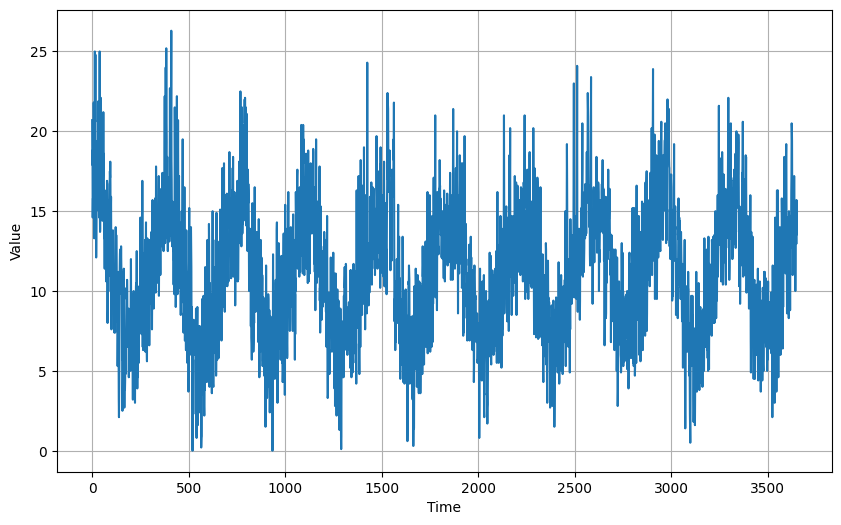

In [5]:

import csv
time_step = []
temps = []

with open(path_to_file) as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

Muestro el tamaño y aspecto de los datos

In [6]:
print(series.shape)
series

(3650,)


array([20.7, 17.9, 18.8, ..., 13.5, 15.7, 13. ])

In [7]:
print(time.shape)
time

(3650,)


array([   0,    1,    2, ..., 3647, 3648, 3649])

# 2. Creación de las variables necesarias para el diseño de la red neuronal

Una técnica muy común cuando se trata con series temporales es utilizar una ventana temporal que se vaya desplazando sobre la serie temporal para reducir su análisis a lo que ocurre en ese ventana de forma local, para a continuación realizar el modelado global.

**Ejercicio 1 (0.4 puntos)**: Crear las variables de entrenamiento y validación y hacer la partición de las mismas. Las variables que hay que crear son:

*   time_train
*   x_train
*   time_valid
*   x_valid





In [1]:
#Variable para controlar la reducción del conjunto del datset y coger una muestra completa o parcial. 
reduce_dataset = False

In [9]:
if not reduce_dataset:
    ## variables para la técnica de la ventana temporal
    split_time = 2900 #Se decide aumentar la muestra para seleccionar el 80% aproximadamente para entrenamiento
    window_size = 30
    batch_size = 32
    shuffle_buffer_size = 1000
else:
    # Muestra de dataset para reducir la carga computacional. 
    time = time[:200]
    series = series[:200]
    split_time = 140
    window_size = 5
    batch_size = 9
    shuffle_buffer_size = 40

In [10]:
## Split del dataset en entrenamiento y validación

time_train =  time[:split_time]
time_valid = time[split_time:]
x_train = series[:split_time]
x_valid = series[split_time:]

# Imprimir las formas de los conjuntos resultantes
print("Forma del conjunto de entrenamiento (time_train):", time_train.shape)
print("Forma del conjunto de entrenamiento (x_train):", x_train.shape)
print("Forma del conjunto de validación (time_valid):", time_valid.shape)
print("Forma del conjunto de validación (x_valid):", x_valid.shape)

# print("Forma del conjunto de entrenamiento (time_train):", time_train)
# print("Forma del conjunto de entrenamiento (x_train):", x_train)
# print("Forma del conjunto de validación (time_valid):", time_valid)
# print("Forma del conjunto de validación (x_valid):", x_valid)

Forma del conjunto de entrenamiento (time_train): (2900,)
Forma del conjunto de entrenamiento (x_train): (2900,)
Forma del conjunto de validación (time_valid): (750,)
Forma del conjunto de validación (x_valid): (750,)
Forma del conjunto de entrenamiento (time_train): [   0    1    2 ... 2897 2898 2899]
Forma del conjunto de entrenamiento (x_train): [20.7 17.9 18.8 ... 16.1 20.2 14.3]
Forma del conjunto de validación (time_valid): [2900 2901 2902 2903 2904 2905 2906 2907 2908 2909 2910 2911 2912 2913
 2914 2915 2916 2917 2918 2919 2920 2921 2922 2923 2924 2925 2926 2927
 2928 2929 2930 2931 2932 2933 2934 2935 2936 2937 2938 2939 2940 2941
 2942 2943 2944 2945 2946 2947 2948 2949 2950 2951 2952 2953 2954 2955
 2956 2957 2958 2959 2960 2961 2962 2963 2964 2965 2966 2967 2968 2969
 2970 2971 2972 2973 2974 2975 2976 2977 2978 2979 2980 2981 2982 2983
 2984 2985 2986 2987 2988 2989 2990 2991 2992 2993 2994 2995 2996 2997
 2998 2999 3000 3001 3002 3003 3004 3005 3006 3007 3008 3009 3010 301

2. Creación del método **windowed_datset** para poder utilizarlo en el modelo. Las entradas por parámetros del método son:

*   series
*   window_size
*   batch_size
*   shuffle_buffer

El resto de elementos que se usan para construir la función ventana temporal para explorar el dataset, son métodos de Python para tratar con series temporales.




# 3. Diseño de la función para predecir los siguientes valores de la serie temporal usando la técnica de la ventana temporal

In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

A continuación, y usando como modelo el método **windowed_dataset** se procederá a adaptar el método **model_forecast** que se usará para predecir los siguientes valores de la serie temporal utilizando la técnica de la ventana temporal.

**Ejercicio 2 (1.6 puntos)**: completar el método model_forecast creando los elementos necesarios dentro del método:

1.   Crear la variable **ds** y darle el valor resultante del método **from_tensor_slices** pasando por parametro **series** **(0.4 puntos)**
2.   Actualizar la ventana (**window**) de la variable **ds** (nota: en este caso el tamaño es el mismo de la ventana, no es necesario que sea window_size+1) **(0.4 puntos)**
3.   Crear el **flat_map** de la variable, teniendo en cuenta que el tamaño es **window_size** **(0.4 puntos)**
4.   Añadir la siguiente linea de código: ds = ds.batch(32).prefetch(1)
5.   Crear la variable **forecast** en la que se usará el método **predict** **(0.4 puntos)**
6.   Por último, se devolverá la variable forecast.




In [13]:
def model_forecast(model, series, window_size):
    # Crear un conjunto de datos TensorFlow a partir de la serie temporal
    ds = tf.data.Dataset.from_tensor_slices(series)
    # Actualizar la ventana (window) de la variable ds
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    # Aplana las ventanas para convertirlas en lotes de tamaño window_size
    ds = ds.flat_map(lambda w: w.batch(window_size))
    # Agregar la siguiente línea de código para agrupar los datos en lotes y prefetch para mejorar la eficiencia
    ds = ds.batch(32).prefetch(1)
    # Crear la variable forecast en la que se usará el método predict
    forecast = model.predict(ds)
    # Redondear los valores a un decimal para que se vean igual que los usados en el entrnamiento
    #Este paso no es estrictamente necesario.
    forecast_rounded = np.round(forecast, 1)
    return forecast_rounded

A continuación, se limpia la sesión de keras, y se inicializan las variables necesarias para poder diseñar el modelo de series temporales a entrenar usando RNN.

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256

# 4. Diseño de la red neuronal

**Ejercicio 3.1 (0.5 puntos)**: Hay que crear la variable **train_set** dandole el valor que se reciba del método **windowed_datset**, los parametros que debe recibir este método son: **x_train, window_size, batch_size, shuffle_buffer_size**

In [15]:
## tu código aquí para el ejercicio 3

# Crear la variable train_set
train_set = windowed_dataset(x_train, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)
print(train_set)


------------- windowed_dataset -- 0  -----------------> <_TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.float64, name=None)>
------------- windowed_dataset -- 1  -----------------> <_WindowDataset element_spec=DatasetSpec(TensorSpec(shape=(1,), dtype=tf.float64, name=None), TensorShape([]))>
------------- windowed_dataset -- 2  -----------------> <_FlatMapDataset element_spec=TensorSpec(shape=(None, 1), dtype=tf.float64, name=None)>
------------- windowed_dataset -- 3  -----------------> <_ShuffleDataset element_spec=TensorSpec(shape=(None, 1), dtype=tf.float64, name=None)>
------------- windowed_dataset -- 4  -----------------> <_MapDataset element_spec=(TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>
------------- windowed_dataset -- 5  -----------------> <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float6

**Ejercicio 3.2 (4 puntos)**: Se debe construir la red neuronal de aprendizaje profunda basada para modelar la serie temporal de las temperaturas minimas diarias. Esta red neuronal debera contar con las siguientes capas ocultas:

1.   Una capa de convolución en una dimensión que tenga 32 filtros, una tamaño del kernel de 5, un stride de 1, padding "causal", la función de activación debe ser relu y el input shape debe ser [None, 1]
2.   Una capa LSTM con 64 neuronas y retorno de secuencias
3.   Una capa LSTM con 64 neuronas y retorno de secuencias
4.   Una capa densa con 30 neuronas
5.   Una capa densa con 10 neuronas
6.   Una capa densa con 1 neuronas
7.   Por último, se añade la siguiente capa: tf.keras.layers.Lambda(lambda x: x * 400)




In [16]:
## tu código para la red neuronal del ejercicio 4 aquí

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Lambda

# Crear el modelo de red neuronal
model = Sequential([
    # Capa de convolución en una dimensión
    Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),

    # Capa LSTM con 64 neuronas y retorno de secuencias
    LSTM(64, return_sequences=True),

    # Capa LSTM con 64 neuronas y retorno de secuencias
    LSTM(64, return_sequences=True),

    # Capa densa con 30 neuronas
    Dense(30, activation="relu"),

    # Capa densa con 10 neuronas
    Dense(10, activation="relu"),

    # Capa densa con 1 neurona
    Dense(1),

    # Capa Lambda para escalar la salida
    Lambda(lambda x: x * 400)
])

# Imprimir un resumen del modelo
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 32)          192       
                                                                 
 lstm (LSTM)                 (None, None, 64)          24832     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          33024     
                                                                 
 dense (Dense)               (None, None, 30)          1950      
                                                                 
 dense_1 (Dense)             (None, None, 10)          310       
                                                                 
 dense_2 (Dense)             (None, None, 1)           11        
                                                                 
 lambda (Lambda)             (None, None, 1)           0

# 5. Entrenamiento de la red neuronal

**Ejercicio 4 (0.5 puntos)**: Se va a diseñar un método callbacks para el learning rate que será guardado en la variable **lr_schedule**, este método deberá usar el método **LearningRateScheduler** de Python y será una función **lambda** que le de el valor a epoch de 1e-8 * 10**(epoch / 20) **texto en negrita**

In [17]:
## tu código para crear la variable lr_schedule aquí
from tensorflow.keras.callbacks import LearningRateScheduler

lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))


**Ejercicio 5 (1.5 puntos):** Compilar la red neuronal con los siguientes parametros:

*   loss: método Huber de keras
*   El optimizador debe ser el SGD con learning rate 1e-8 y momentum 0.9
*   La métrica a visualizar es el error absoluto medio (medium absolute error en ingles)



In [18]:
## tu código para compilar la red neuronal para el ejercicio 5 aquí

# Importar el optimizador SGD
from tensorflow.keras.optimizers import SGD

# Compilar la red neuronal con los parámetros dados
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=SGD(learning_rate=1e-8, momentum=0.9),
              metrics=["mae"])

Para terminar se entrena el modelo previamente diseñado y compilado en los pasos anteriores.

In [19]:
epochs = 100
history = model.fit(train_set, epochs=epochs, callbacks=[lr_schedule])

Epoch 1/100
29/29 [==============================] - 13s 22ms/step - loss: 23.4627 - mae: 23.9580 - lr: 1.0000e-08
Epoch 2/100
29/29 [==============================] - 1s 30ms/step - loss: 20.0205 - mae: 20.5160 - lr: 1.1220e-08
Epoch 3/100
29/29 [==============================] - 1s 36ms/step - loss: 17.9002 - mae: 18.3959 - lr: 1.2589e-08
Epoch 4/100
29/29 [==============================] - 1s 21ms/step - loss: 16.0600 - mae: 16.5554 - lr: 1.4125e-08
Epoch 5/100
29/29 [==============================] - 1s 21ms/step - loss: 14.0754 - mae: 14.5700 - lr: 1.5849e-08
Epoch 6/100
29/29 [==============================] - 1s 20ms/step - loss: 11.9159 - mae: 12.4081 - lr: 1.7783e-08
Epoch 7/100
29/29 [==============================] - 1s 22ms/step - loss: 9.7167 - mae: 10.2070 - lr: 1.9953e-08
Epoch 8/100
29/29 [==============================] - 1s 21ms/step - loss: 7.6362 - mae: 8.1233 - lr: 2.2387e-08
Epoch 9/100
29/29 [==============================] - 1s 21ms/step - loss: 5.9231 - mae: 6.

# 6. Actualización del learning rate según los resultados obtenidos del primer entrenamiento de la red neuronal

Después del entrenamiento de la red neuronal se ve que learning rate resultante es de 1e-5. Se visualizará gráficamente para entender el motivo por el que se ha usado ese valor. En la gráfica se puede ver cómo el learning rate con el que menos loss hay es 1e-5, y por ese motivo, se debe volver a entrenar la red neuronal con dicho learning rate.

(1e-08, 0.0001, 0.0, 60.0)

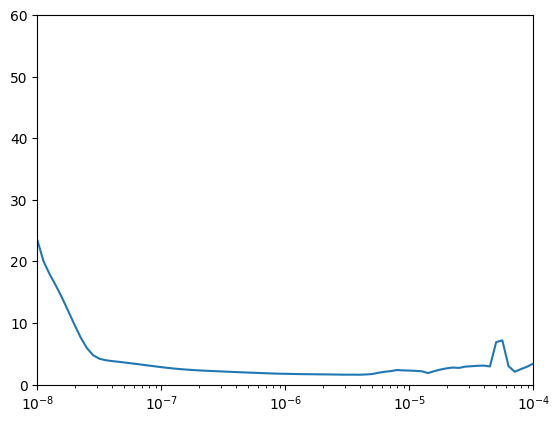

In [20]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

Se vuelve a inicializar la sesión de entrenamiento y la variable train_set:

In [21]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

------------- windowed_dataset -- 0  -----------------> <_TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.float64, name=None)>
------------- windowed_dataset -- 1  -----------------> <_WindowDataset element_spec=DatasetSpec(TensorSpec(shape=(1,), dtype=tf.float64, name=None), TensorShape([]))>
------------- windowed_dataset -- 2  -----------------> <_FlatMapDataset element_spec=TensorSpec(shape=(None, 1), dtype=tf.float64, name=None)>
------------- windowed_dataset -- 3  -----------------> <_ShuffleDataset element_spec=TensorSpec(shape=(None, 1), dtype=tf.float64, name=None)>
------------- windowed_dataset -- 4  -----------------> <_MapDataset element_spec=(TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>
------------- windowed_dataset -- 5  -----------------> <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float6

**Ejercicio 6 (0.5 puntos)**: Para crear el nuevo modelo, reutiliza la red neuronal diseñada en el ejercicio 4, pero esta vez utilizando 60 filtros en la capa de convolución.

In [22]:
## tu código para la red neuronal del ejercicio 6 aquí
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Lambda

# Crear el nuevo modelo de red neuronal
new_model = Sequential([
    # Capa de convolución en una dimensión con 60 filtros
    Conv1D(filters=60, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),

    # Capa LSTM con 64 neuronas y retorno de secuencias
    LSTM(64, return_sequences=True),

    # Capa LSTM con 64 neuronas y retorno de secuencias
    LSTM(64, return_sequences=True),

    # Capa densa con 30 neuronas
    Dense(30, activation="relu"),

    # Capa densa con 10 neuronas
    Dense(10, activation="relu"),

    # Capa densa con 1 neurona
    Dense(1),

    # Capa Lambda para escalar la salida
    Lambda(lambda x: x * 400)
])

# Imprimir un resumen del nuevo modelo
new_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 60)          360       
                                                                 
 lstm (LSTM)                 (None, None, 64)          32000     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          33024     
                                                                 
 dense (Dense)               (None, None, 30)          1950      
                                                                 
 dense_1 (Dense)             (None, None, 10)          310       
                                                                 
 dense_2 (Dense)             (None, None, 1)           11        
                                                                 
 lambda (Lambda)             (None, None, 1)           0

**Ejercicio 7 (0.5 puntos)**: Se debe volver a compilar la red neuronal de manera análoga a la del ejercicio 5, pero esta vez utilizar un learning rate obtenido de la función callback.

In [23]:
## tu código para compilar la red neuronal para el ejercicio 7 aquí
# Obtener el learning rate del objeto LearningRateScheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))
# Obtener el learning rate para la primera época
learning_rate = lr_schedule.schedule(0)
print(learning_rate)

# Compilar la red neuronal con el learning rate obtenido de la función callback
new_model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=SGD(learning_rate=learning_rate, momentum=0.9),
                  metrics=["mae"])



1e-05


In [24]:
epochs=200
history = new_model.fit(train_set,epochs=epochs)

Epoch 1/200
29/29 [==============================] - 5s 23ms/step - loss: 10.8534 - mae: 11.3385
Epoch 2/200
29/29 [==============================] - 1s 22ms/step - loss: 2.3687 - mae: 2.8286
Epoch 3/200
29/29 [==============================] - 1s 20ms/step - loss: 1.8811 - mae: 2.3323
Epoch 4/200
29/29 [==============================] - 1s 22ms/step - loss: 1.8305 - mae: 2.2799
Epoch 5/200
29/29 [==============================] - 1s 21ms/step - loss: 1.7876 - mae: 2.2364
Epoch 6/200
29/29 [==============================] - 1s 23ms/step - loss: 1.7508 - mae: 2.1987
Epoch 7/200
29/29 [==============================] - 1s 37ms/step - loss: 1.7252 - mae: 2.1727
Epoch 8/200
29/29 [==============================] - 1s 21ms/step - loss: 1.7019 - mae: 2.1491
Epoch 9/200
29/29 [==============================] - 1s 21ms/step - loss: 1.6745 - mae: 2.1205
Epoch 10/200
29/29 [==============================] - 1s 21ms/step - loss: 1.6555 - mae: 2.1014
Epoch 11/200
29/29 [===========================

# 7. Predicción de los siguientes valores de la serie temporal

Para concluir la actividad, se usa el método model_forecast que se ha diseñado utilizando el método de la ventana temporal para hacer el nuevo metodo rnn_forecast con el cual se calcularán los nuevos valores de la serie temporal. Posteriormente, se pinta una gráfica para ver esos resultados y comprobar de forma visual que son correctos. Además, se dan los resultados de esas predicciones en forma númerica, de esta forma, este modelo diseñado en esta actividad podría ser el input de un nuevo algoritmo si fuera necesario.

In [25]:
rnn_forecast = model_forecast(new_model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

------------- model_forecast -- 0  -----------------> <_TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.float64, name=None)>
------------- model_forecast -- 1  -----------------> <_WindowDataset element_spec=DatasetSpec(TensorSpec(shape=(1,), dtype=tf.float64, name=None), TensorShape([]))>
------------- model_forecast -- 4  -----------------> <_FlatMapDataset element_spec=TensorSpec(shape=(None, 1), dtype=tf.float64, name=None)>
------------- model_forecast -- 5  -----------------> <_PrefetchDataset element_spec=TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None)>
113/113 [==============================] - 2s 9ms/step
---------------  0  ----------------> (3587, 64, 1)
---------------  1  ----------------> 2836
---------------  2  ----------------> (750,)
---------------  3  ----------------> [12.9 11.8 14.2 14.4 16.1 16.5 19.5 15.6 17.  15.2 13.9 13.1 14.7 15.4
 16.6 14.5 11.2 13.8 13.3 14.1 13.7 14.2 15.9 16.1 15.4 12.7 12.  13.2
 14.5 14.3 13.  13.1 14.  1

In [26]:
# print(time_valid.shape)
# print(x_valid.shape)
# print(rnn_forecast.shape)

(750,)
(750,)
(750,)


In [27]:
# time_valid

array([2900, 2901, 2902, 2903, 2904, 2905, 2906, 2907, 2908, 2909, 2910,
       2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2919, 2920, 2921,
       2922, 2923, 2924, 2925, 2926, 2927, 2928, 2929, 2930, 2931, 2932,
       2933, 2934, 2935, 2936, 2937, 2938, 2939, 2940, 2941, 2942, 2943,
       2944, 2945, 2946, 2947, 2948, 2949, 2950, 2951, 2952, 2953, 2954,
       2955, 2956, 2957, 2958, 2959, 2960, 2961, 2962, 2963, 2964, 2965,
       2966, 2967, 2968, 2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976,
       2977, 2978, 2979, 2980, 2981, 2982, 2983, 2984, 2985, 2986, 2987,
       2988, 2989, 2990, 2991, 2992, 2993, 2994, 2995, 2996, 2997, 2998,
       2999, 3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008, 3009,
       3010, 3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019, 3020,
       3021, 3022, 3023, 3024, 3025, 3026, 3027, 3028, 3029, 3030, 3031,
       3032, 3033, 3034, 3035, 3036, 3037, 3038, 3039, 3040, 3041, 3042,
       3043, 3044, 3045, 3046, 3047, 3048, 3049, 30

In [28]:
# x_valid

array([11. , 14.4, 15.7, 19.7, 20.7, 23.9, 16.6, 17.5, 14.9, 13.6, 11.9,
       15.2, 17.3, 19.8, 15.8,  9.5, 12.9, 12.9, 14.8, 14.1, 14.3, 17.4,
       18.5, 16.8, 11.5,  9.5, 12.2, 15.7, 16.3, 13.6, 12.6, 13.8, 12.1,
       13.4, 17.3, 19.4, 16.6, 13.9, 13.1, 16. , 14.5, 15. , 12.6, 12.5,
       15.2, 16.2, 16.5, 20.1, 20.6, 16.9, 16.5, 16.1, 14.4, 16.3, 15.7,
       14.2, 13.2, 16.8, 18.5, 16.7, 15.3, 15.9, 15.2, 17.5, 18.3, 19.4,
       19.4, 19.5, 20.5, 15.7, 15. , 16.1, 14.3, 13. , 16.2, 17.7, 13.2,
       15.8, 18.5, 20.4, 22. , 19.7, 19.6, 20.3, 18.3, 18.9, 20.3, 21.4,
       18.3, 17.8, 17.7, 12.8, 15.1, 15. , 14.8, 12. , 12.5, 15. , 17.1,
       17.3, 16.9, 16.5, 13.6, 13.2,  9.4,  9.5, 11.8, 10.4,  9.7, 12.6,
       13.3, 15.1, 14.2, 14.2, 19.2, 12.6, 14.2, 11.9, 13.9, 13.5, 15.3,
       13.9, 14. , 12.9,  8.5, 11.4, 10.9, 12. ,  8.6,  9. ,  9.6, 10.2,
        9.8,  8.3, 11. , 11.9, 14. , 15.8, 14.5, 13.2, 14.2, 14.6, 11.8,
       14.4, 10.4, 10.3, 10.8, 10.5,  9.5, 12.5, 13

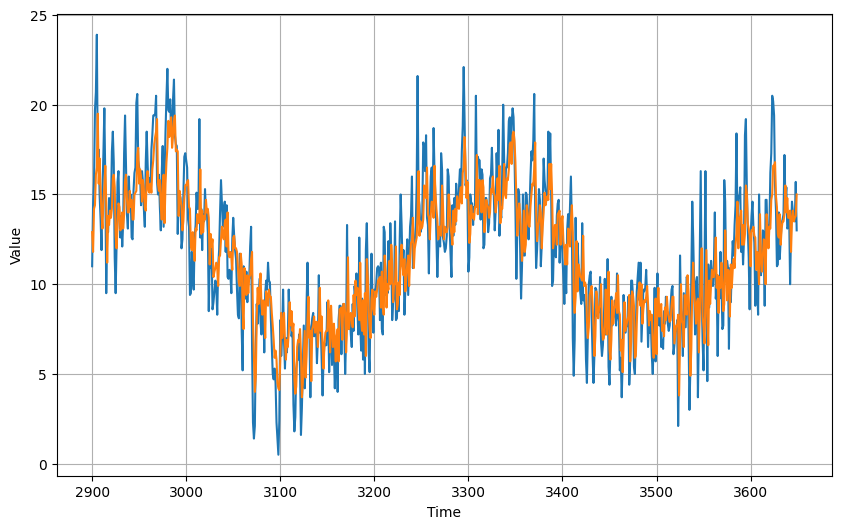

In [29]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [30]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.7589333

In [31]:
print(rnn_forecast)

[12.9 11.8 14.2 14.4 16.1 16.5 19.5 15.6 17.  15.2 13.9 13.1 14.7 15.4
 16.6 14.5 11.2 13.8 13.3 14.1 13.7 14.2 15.9 16.1 15.4 12.7 12.  13.2
 14.5 14.3 13.  13.1 14.  13.1 13.9 15.7 16.1 14.8 14.  14.  15.2 14.3
 14.7 13.6 13.6 15.  15.1 15.2 17.2 17.6 15.6 16.4 16.  14.6 15.8 15.3
 14.3 14.1 15.9 16.3 15.2 15.1 15.6 15.1 16.4 16.9 17.8 18.2 18.5 19.2
 15.6 15.2 15.8 14.4 13.6 15.5 16.1 13.4 15.6 16.8 17.6 19.1 18.2 18.8
 19.3 17.6 18.2 19.1 19.4 17.4 17.5 17.4 13.8 15.2 14.7 14.4 13.  13.5
 14.8 15.5 15.5 15.7 15.8 14.3 14.2 12.1 11.9 12.9 11.9 11.3 13.1 13.
 13.9 13.4 13.8 16.4 12.8 14.1 12.9 13.8 13.6 14.7 14.  14.2 13.7 11.1
 12.8 12.1 12.5 10.4 10.7 10.9 11.2 10.9  9.9 11.5 11.6 12.5 13.2 12.7
 12.5 13.4 13.6 12.1 14.  11.7 11.5 11.8 11.5 10.8 12.6 12.7 12.  12.
 11.8 10.9 10.1  9.9 11.7 11.1  8.6  7.5 10.9  9.7  9.4 10.5  9.5 10.4
 10.5 11.4 11.8  8.   6.1  4.   4.8  8.2  9.8  8.9  9.7 10.6  8.9  8.3
  9.1  8.9  7.   9.6  9.3  8.8  9.7  9.3  9.3  8.4  7.7  6.9  5.9  6.3
  5.8  4

# 8. Mostrar gráficamente los resultados.

Una vez obtenido el resultado de la actividad, se procede a revisr de forma gráfica el training y validation loss a lo largo de los epochs en este nuevo entrenamiento con el learning rate optimizado.

In [32]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Recuperar una lista de resultados de la lista de datos de entrenamiento y pruebas para cada epoch de entrenamiento
#-----------------------------------------------------------
loss=history.history['loss']

epochs_plot=range(len(loss)) # Get number of epochs

A continuación se realiza el plot de la pérdida frente a los epochs

<Figure size 640x480 with 0 Axes>

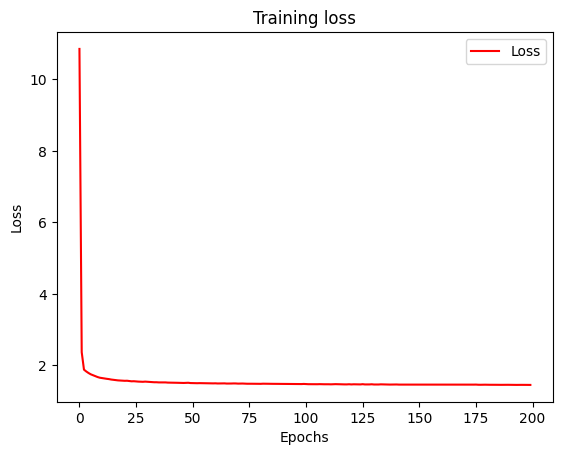

<Figure size 640x480 with 0 Axes>

In [33]:
#------------------------------------------------
# Pérdida de entrenamiento y validación por epoch
#------------------------------------------------
plt.plot(epochs_plot, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

**Ejercicio 8 (0.5 punto)**: Utilizando las 2 nuevas variables zoomed_loss y zoomed_epochs y con base en el código anterior, hacer el plot del loss frente a los epochs entre los epoch 20 y 150 para ver como va oscilando y no es un proceso lineal como podria parecer según el anterior plot.

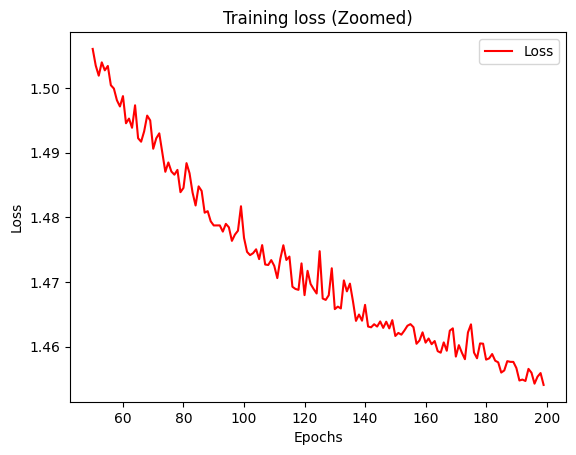

In [34]:
#------------------------------------------------
# Pérdida de entrenamiento y validación por epoch con zoom
#------------------------------------------------
zoomed_loss = loss[50:]
zoomed_epochs = range(50,epochs)
#
## tu código para el plot con zoom del ejercicio 8 aquí
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss (Zoomed)')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])
plt.show()